In [158]:
# Imports
import scipy
from scipy.signal import windows, welch
from scipy.signal.windows import dpss
from scipy.fft import fft, fftfreq
import numpy as np
import math
import matplotlib.pyplot as plt
from spectral_decomposition import spectrum
import scipy.stats as stats
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from spectral_connectivity import Multitaper, Connectivity

# Generating Data

In [159]:
def generate_data(random_state = 42, duration=30):
    data = spectrum(
        sampling_rate=1000,
        duration=duration,
        aperiodic_exponent=2.0,
        aperiodic_offset=0.5,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=False,
        plot=False
    )
    return data.time_domain.combined_signal, data.frequency_domain

# Single Taper (Package)

In [160]:
from scipy.signal import periodogram
def single_taper(signal, N, taper_shape, fs=1000):
    freqs, psd = periodogram(x=signal, window=taper_shape, fs=fs, nfft=N, scaling='density')
    return freqs, psd # later should log freqs and 10*log(power) to get density

# Multitaper

In [161]:
def multitaper(signal, TW = 1, fs=1000):
    K = int(2*TW-1)
    mt = Multitaper(time_series = signal, sampling_frequency = fs, time_halfbandwidth_product=TW, n_tapers = K)
    connectivity = Connectivity.from_multitaper(mt)
    freqs = connectivity.frequencies
    power = connectivity.power().squeeze()
    return freqs, power # later should log freqs and 10*log(power) to get density

# Example Run / Tangible Scaling Visualization Plot

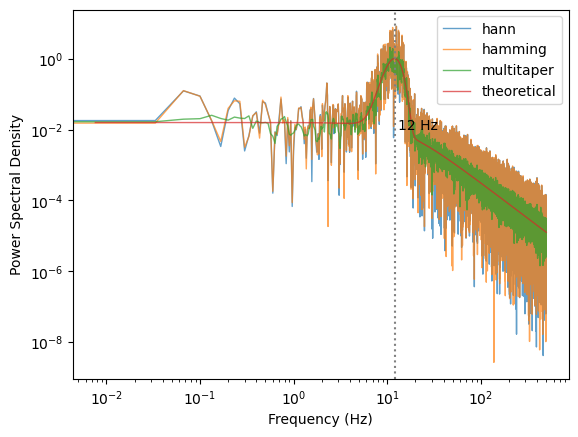

In [162]:
data_td, data_fd = generate_data(random_state=42)

theoretical_freqs_pos = data_fd.frequencies[data_fd.frequencies > 0]
theoretical_psds_pos = data_fd.combined_spectrum[data_fd.frequencies > 0]

window_length = 30
N = window_length*1000
freq_hann, psd_hann = single_taper(data_td, N=N, taper_shape='hann')
freq_hamming, psd_hamming = single_taper(data_td, N=N, taper_shape='hamming')
freq_mt, psd_mt = multitaper(data_td, TW=3)


plt.loglog(freq_hann, psd_hann, linewidth=1, alpha=0.7, label='hann')
plt.loglog(freq_hamming, psd_hamming, linewidth=1, alpha=0.7, label='hamming')
plt.loglog(freq_mt, psd_mt, linewidth=1, alpha=0.7, label='multitaper')
plt.loglog(theoretical_freqs_pos, theoretical_psds_pos, linewidth=1, alpha=0.7, label='theoretical')

plt.axvline(x=12, color='gray', linestyle=':', linewidth=1.5)
plt.text(13, 0.01,'12 Hz')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.show()

# Bias

In [163]:
def calc_biases(empiricalPSD, theoreticalPSD, indices):
    biases = np.zeros((len(indices)))
    for i, index in enumerate(indices):
        biases[i] = empiricalPSD[index] - theoreticalPSD[index]
    return biases

In [164]:
def get_correct_theoretical_window(freq_empirical, freq_theoretical_fd, psd_theoretical_fd):
    """
    Interpolates theoretical PSD onto empirical frequency axis.
    """
    return np.interp(freq_empirical, freq_theoretical_fd, psd_theoretical_fd)

In [165]:
def scale_psd(psd):
    return 10 * np.log10(psd)

In [166]:
durations = [0.05, 0.1, 0.2, 0.5, 1] #seconds
frequencies_of_interest= [12, 30, 50, 80] #Hz
sampling_freq = 1000
TW = 3
K = int(2*TW-1)
iterations = 10000 

for duration in durations:
    bias_hann = np.zeros([iterations, len(frequencies_of_interest)])
    bias_hamm = np.zeros([iterations, len(frequencies_of_interest)])
    bias_multitaper = np.zeros([iterations, len(frequencies_of_interest)])

    for random_state in range(iterations):
        data_td, data_fd = generate_data(duration=duration, random_state=random_state)
        theoretical_freqs_pos = data_fd.frequencies[data_fd.frequencies > 0]
        theoretical_psds_pos = scale_psd(data_fd.combined_spectrum[data_fd.frequencies > 0])
        
        N = int(sampling_freq * duration)
        freq_hann, psd_hann = single_taper(data_td, N=N, taper_shape='hann')
        freq_hamming, psd_hamming = single_taper(data_td, N=N, taper_shape='hamming')
        freq_mt, psd_mt = multitaper(data_td, TW=3)

        psd_hann = scale_psd(psd_hann) 
        psd_hamming = scale_psd(psd_hamming)
        psd_mt = scale_psd(psd_mt)

        idx_hann = [np.argmin(np.abs(freq_hann - f)) for f in frequencies_of_interest]
        idx_hamm = [np.argmin(np.abs(freq_hamming - f)) for f in frequencies_of_interest]
        idx_mt   = [np.argmin(np.abs(freq_mt   - f)) for f in frequencies_of_interest]

        bias_hann[random_state] = calc_biases(psd_hann, get_correct_theoretical_window(freq_hann, theoretical_freqs_pos, theoretical_psds_pos), indices=idx_hann)
        bias_hamm[random_state] = calc_biases(psd_hamming, get_correct_theoretical_window(freq_hamming, theoretical_freqs_pos, theoretical_psds_pos), indices=idx_hamm)
        bias_multitaper[random_state] = calc_biases(psd_mt, get_correct_theoretical_window(freq_mt, theoretical_freqs_pos, theoretical_psds_pos), indices=idx_mt)
    
    df_bias_hann_db = pd.DataFrame(bias_hann, columns=[i for i in frequencies_of_interest])
    df_bias_hamm_db = pd.DataFrame(bias_hamm, columns=[i for i in frequencies_of_interest])
    df_bias_mt_db = pd.DataFrame(bias_multitaper, columns=[i for i in frequencies_of_interest])

    df_bias_hann_db.to_csv(f'./data/bias_hann_db {duration}s.csv', index=False)
    df_bias_hamm_db.to_csv(f'./data/bias_hamm_db {duration}s.csv', index=False)
    df_bias_mt_db.to_csv(f'./data/bias_mt_db {duration}s.csv', index=False)
        

In [167]:
df_bias_hann_1s = pd.read_csv('./data/bias_mt_db 1s.csv')
df_bias_hann_1s = df_bias_hann_1s.melt(var_name='Frequency', value_name='Bias')
df_bias_hann_1s

,Frequency,Bias
0,12,-2.587070
1,12,-2.342950
2,12,1.781650
3,12,-1.548453
4,12,-3.717181
...,...,...
39995,80,-0.230337
39996,80,0.604890
39997,80,0.515850
39998,80,1.184453


In [ ]:
for duration in durations:
    # ——— empty‐signal freq grids ——————————————————————————————————
    N = int(sampling_freq * duration)
    f_hann, _ = periodogram(np.zeros(N), fs=sampling_freq, window='hann',   nfft=N, scaling='density')
    f_hamm, _ = periodogram(np.zeros(N), fs=sampling_freq, window='hamming', nfft=N, scaling='density')
    f_mt      = Connectivity.from_multitaper(
                   Multitaper(np.zeros(N), sampling_frequency=sampling_freq,
                             time_halfbandwidth_product=TW, n_tapers=K)
               ).frequencies
    # ——— find indices of interest ————————————————————————————————
    idx_hann = [np.argmin(np.abs(f_hann - f)) for f in frequencies_of_interest]
    idx_hamm = [np.argmin(np.abs(f_hamm - f)) for f in frequencies_of_interest]
    idx_mt   = [np.argmin(np.abs(f_mt   - f)) for f in frequencies_of_interest]

    bias_hann_db = pd.read_csv(f'./data/bias_hann_db {duration}s.csv').to_numpy()
    bias_hamm_db = pd.read_csv(f'./data/bias_hamm_db {duration}s.csv').to_numpy()
    bias_mt_db = pd.read_csv(f'./data/bias_mt_db {duration}s.csv').to_numpy()

    # ——— plot violins with medians, means, and annotate mean±SD ——————
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    for ax, data_db, fgrid, idxs, title in zip(
        axes,
        [bias_hann_db, bias_hamm_db, bias_mt_db],
        [f_hann,       f_hamm,       f_mt],
        [idx_hann,     idx_hamm,     idx_mt],
        ['Hann',       'Hamming',    'Multitaper']
    ):
            # Convert data to long-form DataFrame
        df = pd.DataFrame({
            "Frequency": np.repeat(frequencies_of_interest, data_db.shape[0]),
            "Bias": np.concatenate([data_db[:, j] for j in idxs])
        })

        sns.violinplot(
            data=df,
            x="Frequency",
            y="Bias",
            ax=ax,
            hue = "Frequency",
            palette = sns.color_palette("Blues", n_colors=len(frequencies_of_interest)),
            legend=False,
            width=0.8,
            cut=0,
            alpha=0.7
        )

        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        
        for i, freq in enumerate(df["Frequency"].unique()):
            group = df[df["Frequency"] == freq]["Bias"]
            ymin, ymax = group.min(), group.max()
            mean = group.mean()
            std = group.std()

            ax.set_title(f'{duration}s window \n ')
            
            # Draw top and bottom lines
            ax.hlines(ymax, i - 0.2, i + 0.2, colors='black', linewidth=1)
            ax.hlines(ymin, i - 0.2, i + 0.2, colors='black', linewidth=1)
            
            # Add mean ± std text above the top line
            ax.text(
                i, ymax + 0.05 * (ymax - ymin),  # Slightly above ymax
                f"{mean:.2f} ± {std:.2f}",
                ha='center', va='bottom', fontsize=9,
                color='black'
            )

    axes[0].set_ylabel('Bias (dB)')
    #plt.suptitle(f'Bias Distributions in dB at Selected Frequencies\n'
                 #f'(mean±SD shown, N={n_iter} runs)')
    plt.tight_layout(rect=[0,0,1,0.7])
    sns.despine()
    plt.show()

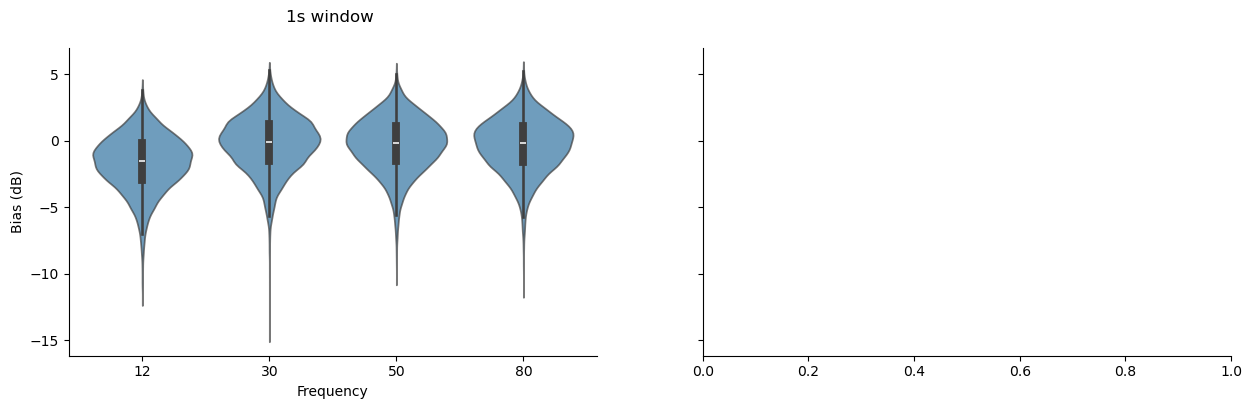

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
ax = axes[0]
sns.violinplot(
            data=df_bias_hann_1s,
            x="Frequency",
            y="Bias",
            ax=ax,
            legend=False,
            width=0.8,
            cut=0,
            alpha=0.7
)
for i, freq in enumerate(frequencies_of_interest):
    group = df_bias_hann_1s[df_bias_hann_1s["Frequency"] == freq]["Bias"]
    ymin, ymax = group.min(), group.max()
    mean = group.mean()
    std = group.std()

    ax.set_title(f'{duration}s window \n ')

    # Draw top and bottom lines
    ax.hlines(ymax, i - 0.2, i + 0.2, colors='black', linewidth=1)
    ax.hlines(ymin, i - 0.2, i + 0.2, colors='black', linewidth=1)

    # Add mean ± std text above the top line
    ax.text(
        i, ymax + 0.05 * (ymax - ymin),  # Slightly above ymax
        f"{mean:.2f} ± {std:.2f}",
        ha='center', va='bottom', fontsize=9,
        color='black'
    )
axes[0].set_ylabel('Bias (dB)')
    #plt.suptitle(f'Bias Distributions in dB at Selected Frequencies\n'
                 #f'(mean±SD shown, N={n_iter} runs)')
sns.despine()
plt.show()

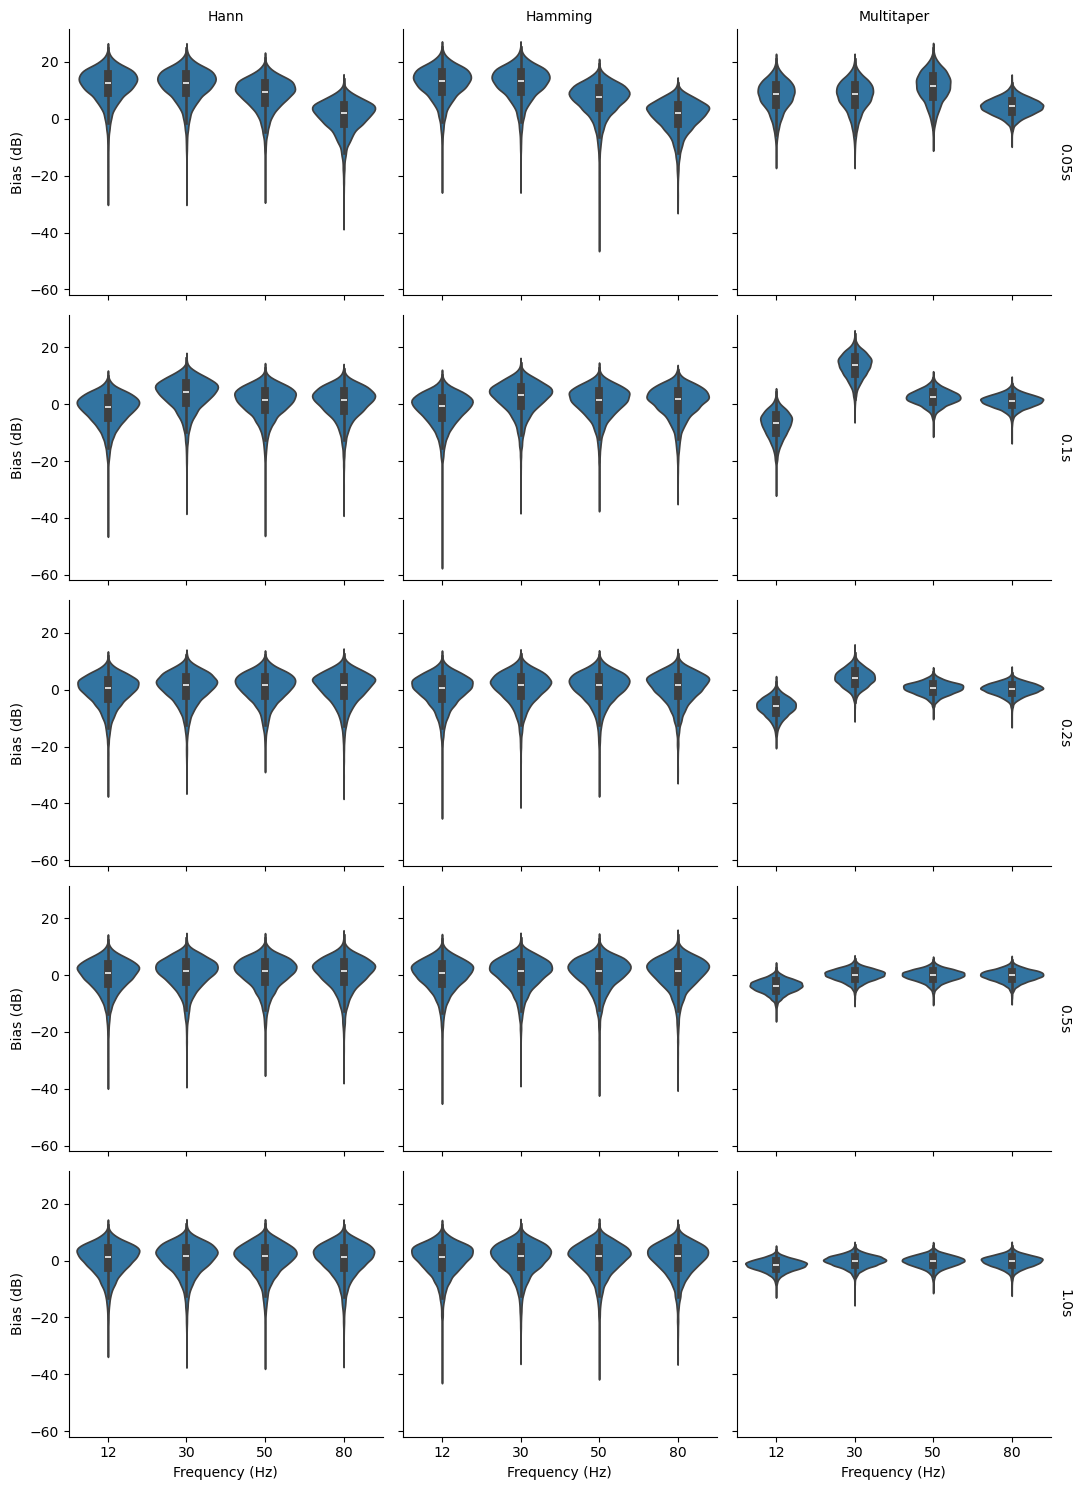

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Settings
durations = [0.05, 0.1, 0.2, 0.5, 1]
frequencies_of_interest = [12, 30, 50, 80]
tapers = ['hann', 'hamm', 'mt']

# Combine all CSVs into one DataFrame for plotting
all_data = []

for duration in durations:
    for taper in tapers:
        file_path = f'./data/bias_{taper}_db {duration}s.csv'
        if not os.path.exists(file_path):
            print(f"Skipping missing file: {file_path}")
            continue
        
        df = pd.read_csv(file_path)
        df = df.melt(var_name='Frequency', value_name='Bias_dB')  # long-form
        df['Frequency'] = df['Frequency'].str.extract(r'(\d+)').astype(int)  # e.g., Freq_12 → 12
        df['Taper'] = taper
        df['Duration'] = duration
        all_data.append(df)

# Combine into one long DataFrame
df_plot = pd.concat(all_data, ignore_index=True)

# Rename for nicer labels
taper_labels = {'hann': 'Hann', 'hamm': 'Hamming', 'mt': 'Multitaper'}
df_plot['Taper'] = df_plot['Taper'].map(taper_labels)

# Plot
g = sns.catplot(
    data=df_plot,
    x='Frequency', y='Bias_dB',
    col='Taper', row='Duration',
    kind='violin',
    sharey=True, sharex=True,
    margin_titles=True,
    height=3, aspect=1.2
)

g.set_titles(row_template='{row_name}s', col_template='{col_name}')
g.set_axis_labels("Frequency (Hz)", "Bias (dB)")
plt.tight_layout()
plt.show()


# Raw Data Processing!

https://physionet.org/content/sleep-edfx/1.0.0/

In [170]:
# import mne
# file_path = "./ST7011J0-PSG.edf"
# raw = mne.io.read_raw_edf(file_path, preload=True) # preload=True loads data into memory
# data = raw.get_data() # Access the signal data
# info = raw.info # Access header information (channels, sampling rate, etc.)

In [171]:
# import pandas as pd
# print(data.T.shape)
# df = pd.DataFrame(data.T, columns=raw.ch_names)

In [172]:
# data_real = df['EEG Fpz-Cz'][1100000:1200000] # get a certain arbitrary electrode

In [173]:
# plt.plot((df.index/100)[1100000:1200000], df['EEG Fpz-Cz'][1100000:1200000])

In [174]:
# real_data_sampling_frequency = 100 # Hz, samples/s
# window_length_options = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5] # seconds
# df_real = pd.DataFrame(columns=['window_length', 'taper_shape', 'freq, psd'])
# for window_length in window_length_options:
#     num_samples = int(window_length * real_data_sampling_frequency) # number of samples in window
#     df_real.loc[len(df_real)] = [window_length, 'hann', single_taper_no_welch(data_real, window_length=window_length, taper_shape='hann')]
#     df_real.loc[len(df_real)] = [window_length, 'hamming', single_taper_no_welch(data_real, window_length=window_length, taper_shape='hamming')]
#     df_real.loc[len(df_real)] = [window_length, 'multitaper', multitaper_package_implementation(data_real, window_length=window_length, TW=1)]

In [175]:
# df_real[['freq', 'psd']] = pd.DataFrame(df_real['freq, psd'].tolist(), index=df_real.index)

# Hann Graph

In [176]:
# plt.title('PSD representation by time window, Hann')
# for window_length in window_length_options:
#     plt.loglog(df_real[(df_real['taper_shape'] == 'hann') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
#             df_real[(df_real['taper_shape'] == 'hann') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
#             label=f"{window_length} s",
#             alpha=0.6)
# plt.legend()

# Hamming Graph

In [177]:
# plt.title('PSD representation by time window, Hamming')
# for window_length in window_length_options:
#     plt.loglog(df_real[(df_real['taper_shape'] == 'hamming') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
#             df_real[(df_real['taper_shape'] == 'hamming') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
#             label=f"{window_length} s",
#             alpha=0.6)
# plt.legend()

# Multitaper Graph!

In [178]:
# plt.title('PSD representation by time window, Multitaper')
# for window_length in window_length_options:
#     plt.loglog(df_real[(df_real['taper_shape'] == 'multitaper') & (df_real['window_length'] == window_length)]['freq'].iloc[0],
#             df_real[(df_real['taper_shape'] == 'multitaper') & (df_real['window_length'] == window_length)]['psd'].iloc[0],
#             label=f"{window_length} s",
#             alpha=0.6)
# plt.legend()